In [84]:
import numpy as np
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
def logist(o):
    flo = float(torch.sum(torch.exp(o)))
    return torch.exp(o)/flo

# Useful fns

def diffnormaliser(array):
    """
    Takes in np array takes increment series and normalises it.
    """
    diff = np.diff(array)
    return diff/np.average(np.abs(diff))

def totensor(array):
    """
    converts to tensor and puts array to device
    """
    return torch.tensor(array)[None,:].to(device)

In [7]:
from fbm import FBM

In [67]:
grid_points = 64 # was 128
num_of_train = 50000 # 500
batch = 100 # 10
epochs = 2

In [42]:
H=0.4
f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
f.fbm().shape

(65,)

In [43]:
%%time
fbm = []


num_test = 50000
rand_test = []

for j in range(num_test):
    H = random.uniform(0.01,1.0)

    f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
    h = f.fbm()
    h = diffnormaliser(h)
        
    fbm.append((h, 1))

CPU times: user 1min 5s, sys: 370 ms, total: 1min 6s
Wall time: 1min 6s


In [44]:
print(fbm[7][0].shape)

(64,)


In [14]:
(np.random.rand(grid_points)-1/2*np.ones(grid_points))*1/2

array([ 0.14747984,  0.09235608, -0.09515274, -0.04601731, -0.13184322,
        0.01123549,  0.02085147, -0.01915297,  0.20298973,  0.23639625,
        0.01910204, -0.2485063 ,  0.07215751, -0.13037806, -0.16540962,
       -0.15034477, -0.04266779,  0.18391817, -0.04892761, -0.10351286,
        0.06611858,  0.02999556,  0.10456931, -0.02255866,  0.15235294,
       -0.15887416,  0.13416436,  0.0949227 , -0.00384499, -0.18955774,
        0.21126984, -0.18897561, -0.0691606 , -0.01940893,  0.12190715,
       -0.19080963, -0.14501591,  0.22555856,  0.14836434,  0.08472051,
        0.17726187,  0.242352  , -0.09253499,  0.04238521, -0.24329207,
       -0.03249894, -0.18264391,  0.15881261, -0.14763619,  0.07360771,
       -0.14080724, -0.2391705 , -0.18069324,  0.22491432,  0.02516505,
        0.13896701,  0.04641048, -0.0652627 , -0.04409985,  0.19661338,
        0.22029413, -0.00347707, -0.0080731 ,  0.01963634])

In [45]:
%%time



for i in range(50000):
    h = (np.random.rand(grid_points+1)-1/2*np.ones(grid_points+1))*1/2
    h = diffnormaliser(h)
    fbm.append((h,0))
# for i in range(10000):
#   fbm.append((np.random.rand(128),0))

CPU times: user 913 ms, sys: 26.5 ms, total: 940 ms
Wall time: 929 ms


In [46]:
import copy
copied = copy.deepcopy(fbm)

In [30]:
# with open('fbm_binary_classification', 'wb') as fp:
#     pickle.dump(fbm, fp)

In [31]:
# with open('fbm_binary_classification', 'rb') as fp:
#     fbm = pickle.load(fp)

In [68]:
random.shuffle(fbm)
num = len(fbm)

In [69]:
num

100000

In [70]:
train_data = fbm[:num*8//10]
test_data = fbm[num*8//10:]

In [71]:
print(len(train_data))
print(len(test_data))
train_data[0][0].size

80000
20000


64

In [72]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=False)

In [73]:
p=0.4
class CNN_simplistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=9, padding='same')
        self.conv2 = nn.Conv1d(32, 32, kernel_size=9, padding='same')
        self.conv3 = nn.Conv1d(32, 64, kernel_size=9, padding='same')
        self.fc1 = nn.Linear(grid_points*64//4, 256)
        self.fc2 = nn.Linear(256, 190)
        # self.fc3 = nn.Linear(190, 190)
        self.fc4 = nn.Linear(190, 2)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        # x = F.avg_pool1d(x, kernel_size=2)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool1d(x, kernel_size=2)

        # conv layer 3
        x = self.dropout(self.conv3(x))
        x = F.relu(x)
        x = F.avg_pool1d(x, kernel_size=2)
          
        
        
        # fc layer 1
        x = x.view(-1,grid_points*64//4)
        x = self.fc1(x)
        x = F.relu(x)
        
        #fc layer 2
        x = self.fc2(x)
        x = F.relu(x)

        # #fc layer 3
        # x = self.fc3(x)
        # x = F.relu(x)

        x=self.fc4(x)
        
        return x

In [74]:
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

## Training
# Instantiate model  
model_simp = CNN_simplistic().double().to(device) 




# Loss and Optimizer
base_optimizer = torch.optim.SGD
optimizer = torch.optim.Adam(model_simp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss



# Iterate through train set minibatchs 
for epoch in trange(epochs):  
    for images, labels in tqdm(train_loader):
        images = images[:,None,:].to(device)
        labels = labels.to(device)
        # Zero out the gradients
        optimizer.zero_grad()

        # ADAM
        # Forward pass
        x = images
        y = model_simp(x)
        
        loss = criterion(y, labels)


        
        # Backward pass
        loss.backward()
        optimizer.step()

## Testing
correct = 0
total = len(test_loader)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        images = images[:,None,:].to(device)
        labels = labels.to(device)
        # Forward pass
        x = images  # <---- change here 
        y = model_simp(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}%'.format(correct/total))



Test accuracy: 98.93499755859375%


tensor([[-24.0936,  23.4050]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
tensor([[-58.8215,  57.0993]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
tensor([[2.3529e-21, 1.0000e+00]], dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([[4.5315e-51, 1.0000e+00]], dtype=torch.float64, grad_fn=<DivBackward0>)


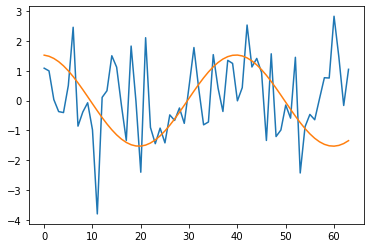

In [88]:
H = 0.6

f = FBM(n=grid_points, hurst=H, length=1, method='daviesharte')
g = diffnormaliser(f.fbm())
plt.plot(g)
g = totensor(g)
t = np.sin(10*np.linspace(0,1,grid_points+1))
t = diffnormaliser(t)

plt.plot(t)
t = totensor(t)





o = model_simp(g)
l = model_simp(t)
print(o)
print(l)

print(logist(o))
print(logist(l))

[*********************100%***********************]  1 of 1 completed
                                  Open         High          Low        Close  \
Datetime                                                                        
2022-06-14 09:30:00-04:00  2130.699951  2139.510010  2130.699951  2137.709961   
2022-06-14 09:31:00-04:00  2136.879883  2138.995117  2135.985107  2138.600098   
2022-06-14 09:32:00-04:00  2142.290039  2146.239990  2134.620117  2134.699951   
2022-06-14 09:33:00-04:00  2137.149902  2142.024902  2135.909912  2142.024902   
2022-06-14 09:34:00-04:00  2142.590088  2142.590088  2135.919922  2138.679932   
...                                ...          ...          ...          ...   
2022-06-14 15:56:00-04:00  2138.489990  2139.620117  2137.199951  2137.885010   
2022-06-14 15:57:00-04:00  2137.340088  2138.139893  2136.620117  2137.129883   
2022-06-14 15:58:00-04:00  2137.989990  2139.080078  2136.739990  2138.294922   
2022-06-14 15:59:00-04:00  2138.780029  

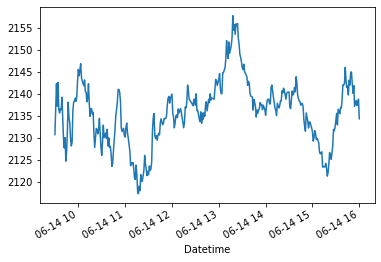

In [76]:
import yfinance as yf
import pandas as pd

# Get the data
data = yf.download(tickers="GOOGL", period="1d", interval="1m")
# data = yf.download("AAPL", start="2017-01-01", end="2020-04-30")
data['Open'].plot()
print(data)

# Print the data
nparray = np.array(data['Open'])
print(nparray)

In [82]:
arr = nparray[:grid_points+1]

arr = diffnormaliser(arr)
arr = totensor(arr)

print(model_simp(arr))

tensor([[-15.6710,  15.1595]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
